# Курсовой проект для курса "Библиотеки Python для Data Science"

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [554]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

%matplotlib inline

In [555]:
# Отчёт классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    # Поменял местами y_test_true и y_test_pred, чтобы результат был больше похож на матрицу ошибок 
    # (т.е. чтобы в строке были предсказанные значения, а в столбце реальные значения)
    print(pd.crosstab(y_test_pred, y_test_true))

In [556]:
# Построение графиков обучения
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [557]:
# Балансировка выборки
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [558]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [559]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [560]:
PATH_TEST_DS = 'course_project_test.csv'
PATH_TRAIN_DS = 'course_project_train.csv'
SCALER_FILE_PATH = 'scaler.pkl'

###  Обзор обучающего датасета

In [561]:
df = pd.read_csv(PATH_TRAIN_DS)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [562]:
df.shape

(7500, 17)

In [563]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [564]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Анализ целевой переменной

In [565]:
target_name = 'Credit Default'
feature_names = df.columns.drop(target_name).tolist()
all_features = feature_names + [target_name]

In [566]:
df[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

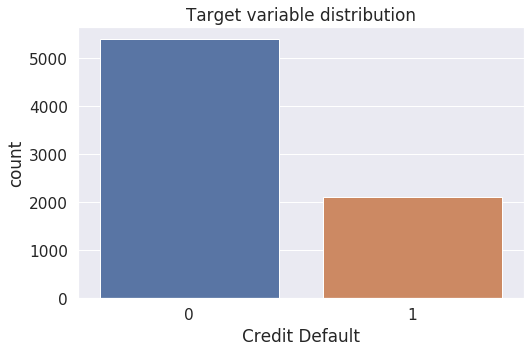

In [567]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target_name, data=df)
plt.title('Target variable distribution')
plt.show()

In [568]:
target_mean = df[target_name].mean()
target_median = df[target_name].median()
target_mode = df[target_name].mode()[0]

target_mean, target_median, target_mode

(0.28173333333333334, 0.0, 0)

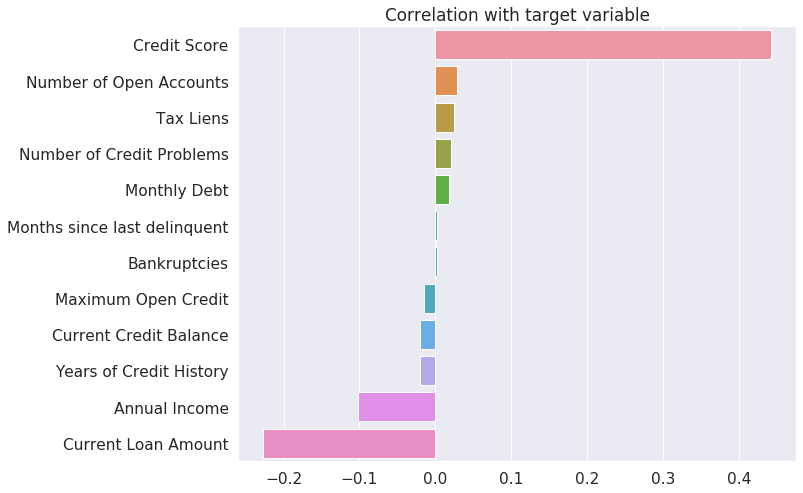

In [569]:
corr_with_target = df[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

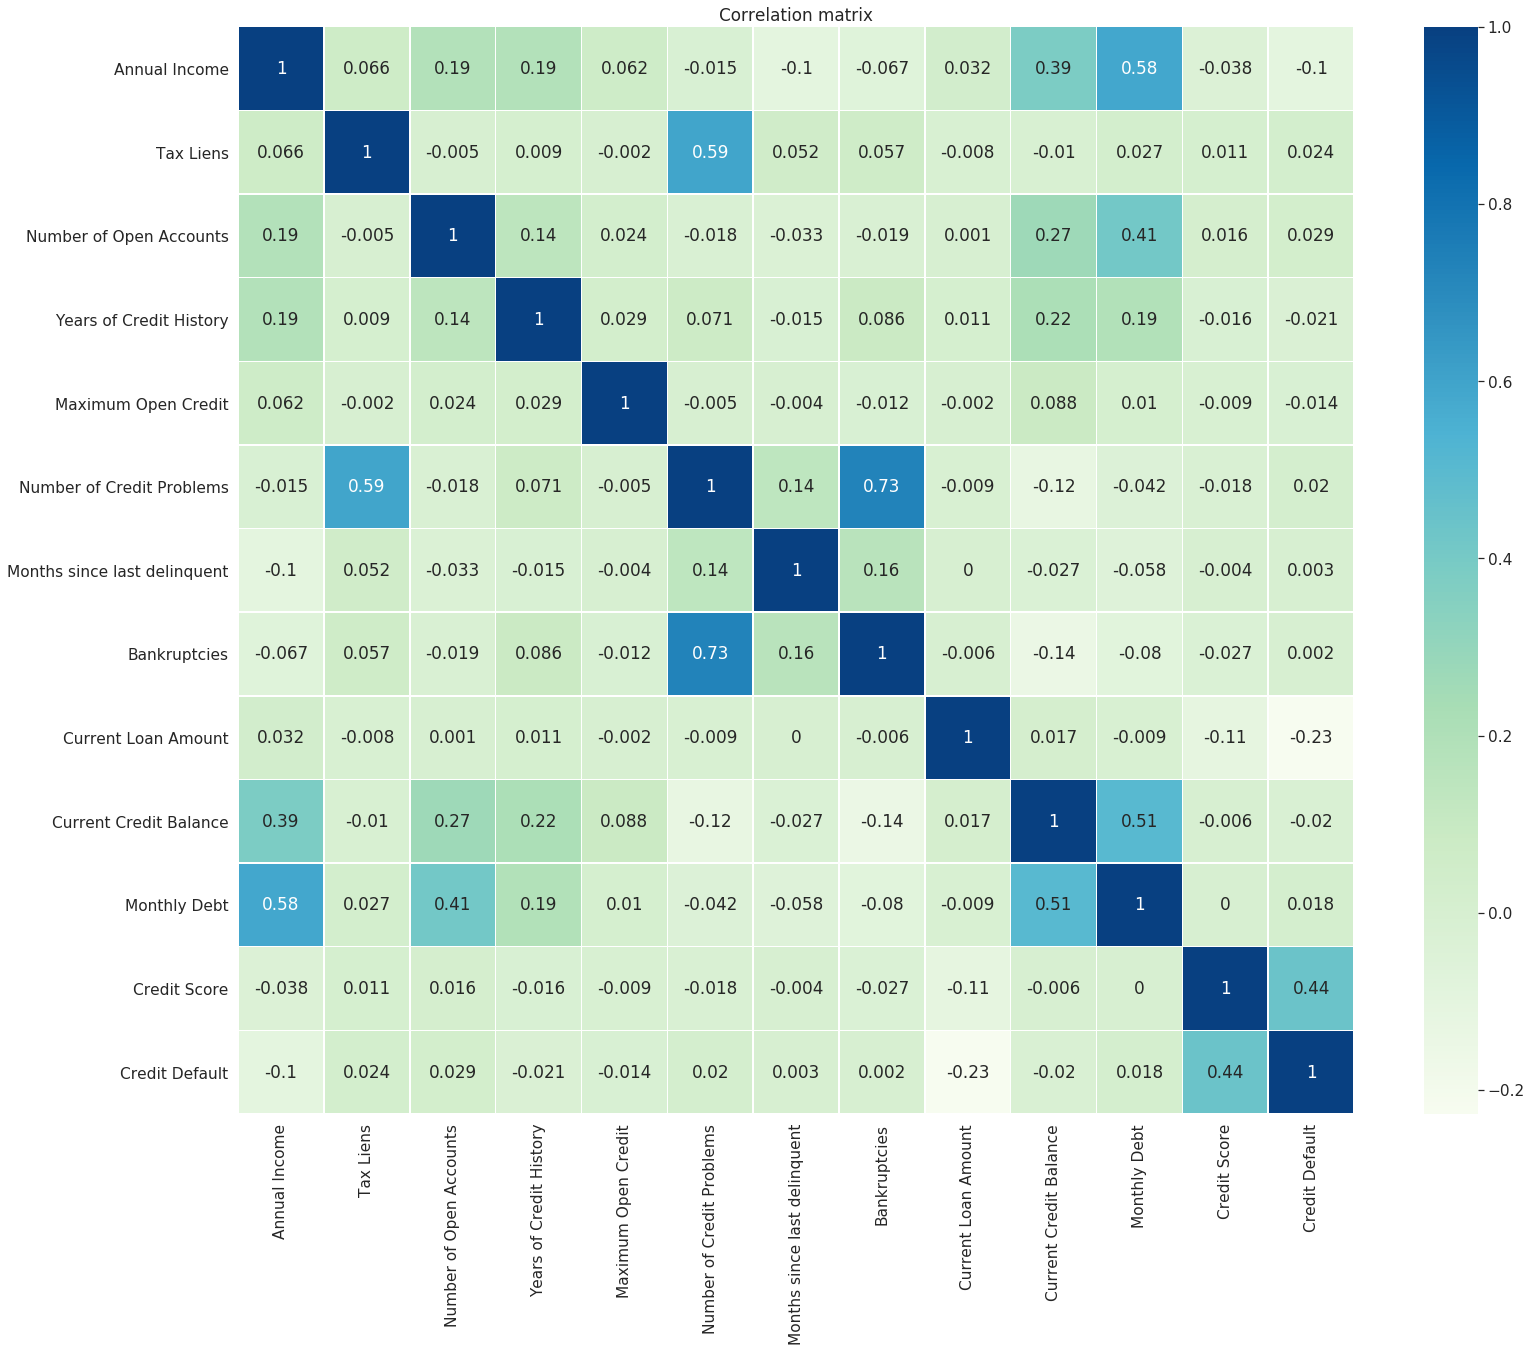

In [570]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

In [571]:
#sns.pairplot(df, height=5)

### Обработка пропусков и построение новых признаков

In [572]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [573]:
# Заменим категориальный признак 'Years in current job' на числовой
dict_ycj = { '< 1 year': 0, 
             '1 year': 1, 
             '2 years': 2, 
             '3 years': 3, 
             '4 years': 4,
             '5 years': 5, 
             '6 years': 6,
             '7 years': 7,
             '8 years': 8, 
             '9 years': 9,
             '10+ years': 10
           }

In [574]:
# Составим словарь среднего значения целевой переменной по 'Credit Score'
dict_cs_m = df[~df['Credit Score'].isna()].groupby(['Credit Score']).\
    agg({'Credit Default':'mean'})['Credit Default'].sort_index()
dict_cs_m.head(10)

Credit Score
585.0    1.000000
586.0    1.000000
588.0    1.000000
589.0    1.000000
590.0    0.000000
591.0    1.000000
593.0    1.000000
594.0    0.333333
597.0    0.000000
598.0    0.000000
Name: Credit Default, dtype: float64

In [575]:
# Обработка признаков
def processing(i_df):
    i_df['Years in current job'] = i_df['Years in current job'].apply(lambda x: dict_ycj.get(x, -1))
    
    # Замена пропусков на медиану
    median_fields = ['Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
    for mf in median_fields:
        med = df[mf].median()
        df[mf].fillna(value=med, inplace=True)
        print(f'{mf}: {med}')

    i_df = pd.get_dummies(i_df, drop_first=True)
    return i_df

In [576]:
# Обработка признаков
def processing2(i_df):
    i_df['Years in current job'] = i_df['Years in current job'].apply(lambda x: dict_ycj.get(x, -1))
    
    dict_ai_med = df.groupby(['Years in current job']).agg({'Annual Income':'median'})['Annual Income'].to_dict()
    df.loc[df['Annual Income'].isna(), 'Annual Income'] = df.loc[df['Annual Income'].isna(), \
        'Years in current job'].apply(lambda x: dict_ai_med.get(x))    

    i_df.loc[i_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1
    i_df.loc[i_df['Bankruptcies'].isna(), 'Bankruptcies'] = -1
    i_df.loc[i_df['Credit Score'].isna(), 'Credit Score'] = -1
    
    #df['Current Loan Amount 99999999'] = ((df['Current Loan Amount']==99999999)*1).astype(np.uint8)
    #df['Credit Score > 5000'] = ((df['Credit Score']>5000)*1).astype(np.uint8)
    i_df['Credit Score Default'] = i_df['Credit Score'].apply(lambda x: \
        dict_cs_m.iat[dict_cs_m.index.searchsorted(x, side='left')])
    
    #i_df['Boost'] = i_df['Annual Income'] * i_df['Monthly Debt'] * i_df['Current Loan Amount']
    #i_df['Boost2'] = list(map(lambda x, y: 1 if x==99999999 else 
    #                    dict_cs_m.iat[dict_cs_m.index.searchsorted(y, side='left')], 
    #                    i_df['Current Loan Amount'], i_df['Credit Score']))
    
    #dict_cs_mode = df.groupby(['Credit Score']).agg({'Credit Default': lambda x: x.mode()[0]})['Credit Default'].sort_index()
    #dict_cs_mode.head(10)
    
    #cla_med = df[df['Current Loan Amount']!=99999999]['Current Loan Amount'].median()
    #df.loc[df['Current Loan Amount']==99999999, 'Current Loan Amount'] = 0 #df.loc[
    #    df['Current Loan Amount']==99999999, 'Current Loan Amount'].apply(lambda x: cla_med)
    
    i_df = pd.get_dummies(i_df, drop_first=True)
    return i_df

In [577]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [578]:
df_copy = df.copy()

In [579]:
len(df[(df['Credit Score'].isna() & (df['Credit Default'] == 0))])

1028

In [580]:
# Удалим строки с пустым Credit Score для таргета 0
df = df[~(df['Credit Score'].isna() & (df['Credit Default'] == 0))]

In [581]:
len(df) - df.count()

Home Ownership                     0
Annual Income                    529
Years in current job             332
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    3486
Bankruptcies                      12
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     529
Credit Default                     0
dtype: int64

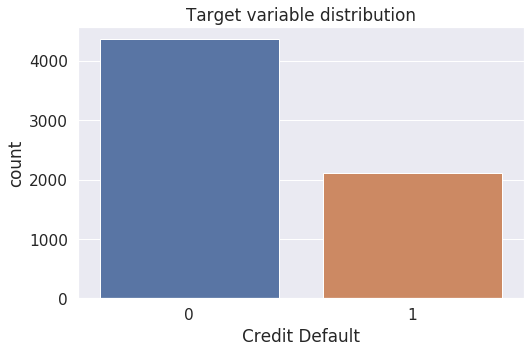

In [582]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target_name, data=df)
plt.title('Target variable distribution')
plt.show()

In [583]:
# Обработка датасетов
df = processing(df)
df_copy = processing(df_copy)

Annual Income: 1168386.0
Months since last delinquent: 32.0
Bankruptcies: 0.0
Credit Score: 731.0
Annual Income: 1168386.0
Months since last delinquent: 32.0
Bankruptcies: 0.0
Credit Score: 731.0


### Приведение типов данных

In [584]:
df.select_dtypes(include=['uint8'])

,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7493,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7495,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
7496,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [585]:
# Категориальные признаки
#cat_feature_names = df.select_dtypes(include=['uint8']).columns
#for colname in cat_feature_names:
#    df[colname] = pd.Categorical(df[colname])

In [586]:
df[cat_feature_names].dtypes

Home Ownership_Home Mortgage    uint8
Home Ownership_Own Home         uint8
Home Ownership_Rent             uint8
Purpose_buy a car               uint8
Purpose_buy house               uint8
Purpose_debt consolidation      uint8
Purpose_educational expenses    uint8
Purpose_home improvements       uint8
Purpose_major purchase          uint8
Purpose_medical bills           uint8
Purpose_moving                  uint8
Purpose_other                   uint8
Purpose_renewable energy        uint8
Purpose_small business          uint8
Purpose_take a trip             uint8
Purpose_vacation                uint8
Purpose_wedding                 uint8
Term_Short Term                 uint8
dtype: object

### Стандартизация признаков

stand_feature_names = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                       'Years of Credit History', 'Maximum Open Credit', 
                       'Number of Credit Problems', 
                       'Months since last delinquent', 
                       'Bankruptcies', 
                       #'Power_NCP_B',
                       'Current Loan Amount', 
                       'Current Credit Balance', 'Monthly Debt', 'Credit Score']
scaler = StandardScaler()
df[stand_feature_names] = scaler.fit_transform(df[stand_feature_names])

In [587]:
#df.describe()

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

## Обучение XGBClassifier

In [588]:
feature_names = df.columns.drop([target_name]).tolist()
all_features = feature_names + [target_name]

In [589]:
X = df[feature_names]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

In [590]:
# Балансировка
print(y_train.value_counts())

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
print(df_balanced[target_name].value_counts())

X_train_bal = df_balanced.drop(columns=target_name)
y_train_bal = df_balanced[target_name]

0    3246
1    1608
Name: Credit Default, dtype: int64
0    3246
1    3216
Name: Credit Default, dtype: int64


0.8447535639220102
{'max_depth': 4, 'n_estimators': 500}
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3246
           1       1.00      1.00      1.00      1608

    accuracy                           1.00      4854
   macro avg       1.00      1.00      1.00      4854
weighted avg       1.00      1.00      1.00      4854

TEST

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1113
           1       0.67      0.60      0.63       505

    accuracy                           0.78      1618
   macro avg       0.75      0.73      0.74      1618
weighted avg       0.78      0.78      0.78      1618

CONFUSION MATRIX

Credit Default    0    1
row_0                   
0               963  201
1               150  304


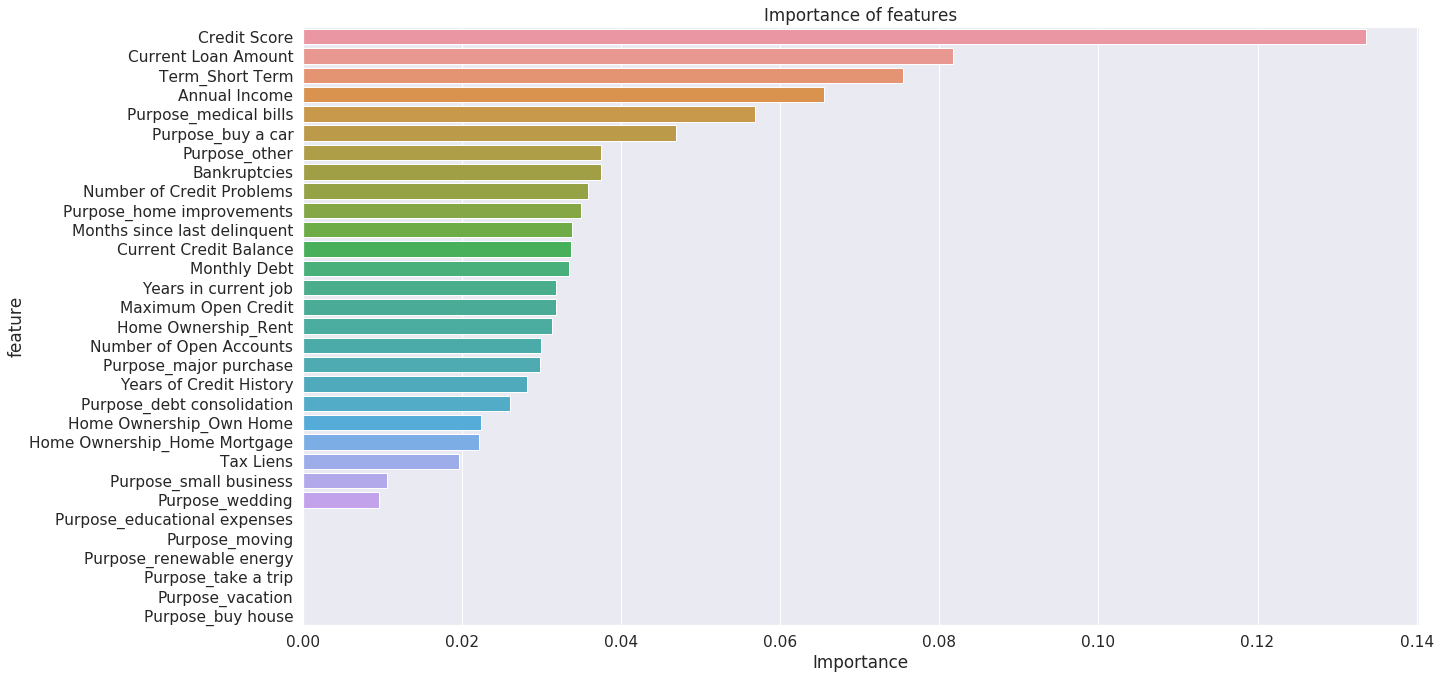

CPU times: user 10.2 s, sys: 228 ms, total: 10.4 s
Wall time: 6.74 s


In [591]:
%%time

params = {'n_estimators': [100, 500, 1000],
          'max_depth': [2, 3, 4]}
#params = {'n_estimators': [500],
#          'max_depth': [3]}
    
xgb_model = xgb.XGBClassifier(random_state=21)
gs = GridSearchCV(xgb_model, params, scoring='f1', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X_train_bal, y_train_bal)

print(gs.best_score_)
print(gs.best_params_)

y_train_pred = gs.best_estimator_.predict(X_train)
y_test_pred = gs.best_estimator_.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

important_features_top = show_feature_importances(X_train.columns, gs.best_estimator_.feature_importances_, 
                                                  get_top=15)

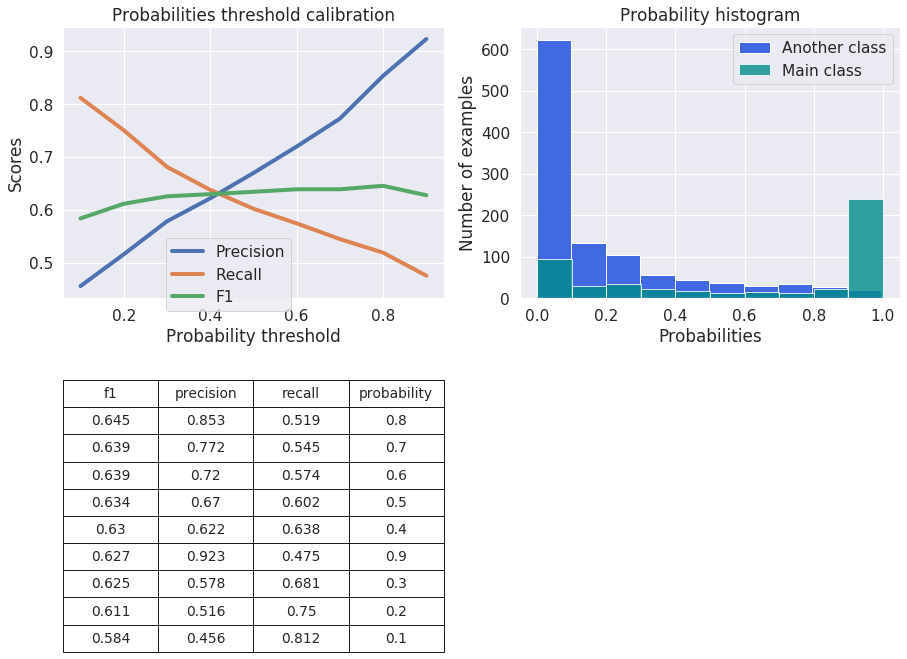

In [592]:
y_test_pred_probs = gs.best_estimator_.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [593]:
X = df[important_features_top]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

In [594]:
# Балансировка
print(y_train.value_counts())

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
print(df_balanced[target_name].value_counts())

X_train_bal = df_balanced.drop(columns=target_name)
y_train_bal = df_balanced[target_name]

0    3246
1    1608
Name: Credit Default, dtype: int64
0    3246
1    3216
Name: Credit Default, dtype: int64


0.8502977150267791
{'max_depth': 4, 'n_estimators': 500}
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3246
           1       1.00      1.00      1.00      1608

    accuracy                           1.00      4854
   macro avg       1.00      1.00      1.00      4854
weighted avg       1.00      1.00      1.00      4854

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1113
           1       0.63      0.61      0.62       505

    accuracy                           0.77      1618
   macro avg       0.73      0.72      0.72      1618
weighted avg       0.76      0.77      0.76      1618

CONFUSION MATRIX

Credit Default    0    1
row_0                   
0               933  199
1               180  306


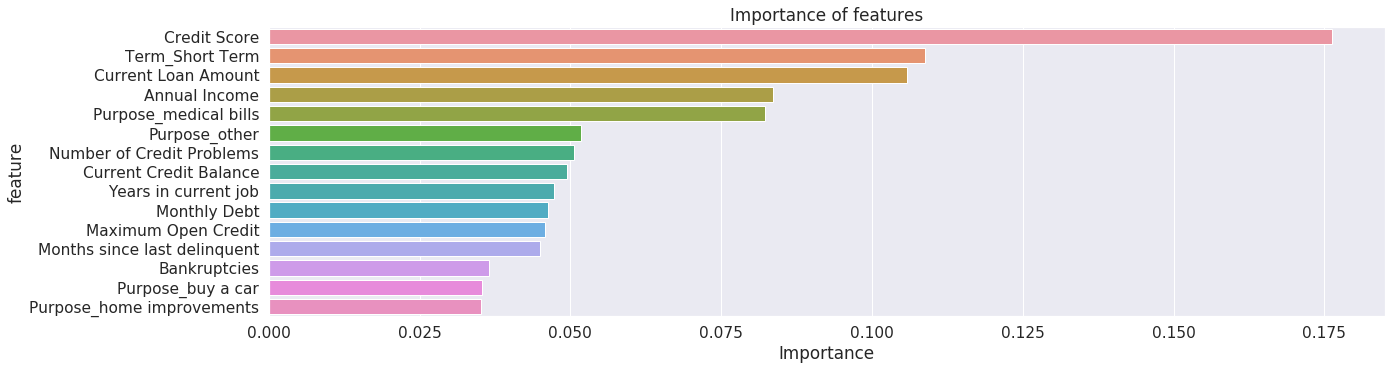

CPU times: user 10.7 s, sys: 115 ms, total: 10.8 s
Wall time: 4.94 s


['Credit Score',
 'Term_Short Term',
 'Current Loan Amount',
 'Annual Income',
 'Purpose_medical bills',
 'Purpose_other',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Years in current job',
 'Monthly Debt',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose_buy a car',
 'Purpose_home improvements']

In [595]:
%%time

params = {'n_estimators': [100, 500, 1000],
          'max_depth': [2, 3, 4]}
#params = {'n_estimators': [500],
#          'max_depth': [3]}
    
xgb_model = xgb.XGBClassifier(random_state=21)
gs = GridSearchCV(xgb_model, params, scoring='f1', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X_train_bal, y_train_bal)

print(gs.best_score_)
print(gs.best_params_)

y_train_pred = gs.best_estimator_.predict(X_train)
y_test_pred = gs.best_estimator_.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

show_feature_importances(X_train.columns, gs.best_estimator_.feature_importances_, get_top=15)

In [596]:
X_test = df_copy[important_features_top] #feature_names]
y_test = df_copy[target_name]

y_test_pred = gs.best_estimator_.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3246
           1       1.00      1.00      1.00      1608

    accuracy                           1.00      4854
   macro avg       1.00      1.00      1.00      4854
weighted avg       1.00      1.00      1.00      4854

TEST

              precision    recall  f1-score   support

           0       0.94      0.78      0.86      5387
           1       0.61      0.87      0.72      2113

    accuracy                           0.81      7500
   macro avg       0.78      0.83      0.79      7500
weighted avg       0.85      0.81      0.82      7500

CONFUSION MATRIX

Credit Default     0     1
row_0                     
0               4226   272
1               1161  1841


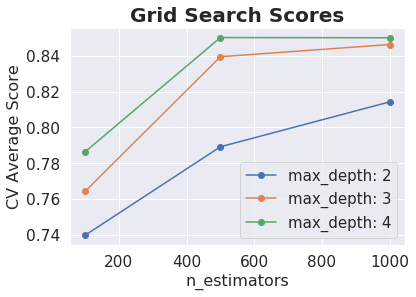

In [597]:
plot_grid_search(gs.cv_results_, params['n_estimators'], params['max_depth'], 'n_estimators', 'max_depth')

In [598]:
print(f1_score(y_train, y_train_pred))
print(f1_score(y_test, y_test_pred) )

1.0
0.7198435972629521


In [599]:
#with open(MODEL_FILE_PATH, 'wb') as file:
#    pickle.dump(fgs.best_estimator_, file)

## Предскажем классы для тестовой выборки и запишем результаты в файл

In [600]:
df_test = pd.read_csv(PATH_TEST_DS)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [601]:
df_test = processing(df_test)

Annual Income: 1168386.0
Months since last delinquent: 32.0
Bankruptcies: 0.0
Credit Score: 731.0


In [602]:
#y_pred = gs.best_estimator_.predict(df_test[feature_names])
y_pred = gs.best_estimator_.predict(df_test[important_features_top])
result = pd.DataFrame({ 'Credit Default': y_pred })
result.head()

,Credit Default
0,0
1,1
2,1
3,0
4,0


In [603]:
result.to_csv('RSemenov_predictions.csv', sep=',', index=True, encoding='utf-8')